In [18]:
import numpy as np


### The Class

In [19]:

#%%writefile ../quantile_comparer.py
# Partial Ranker
#
# Copyright (C) 2019-2024, Aravind Sankaran
# IRTG-2379: Modern Inverse Problems, RWTH Aachen University, Germany
# HPAC, Umeå University, Sweden
#
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# any later version.
#
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <http://www.gnu.org/licenses/>.
#
# Contributors:
# - Aravind Sankaran

import numpy as np

class QuantileComparer:
    """
    Given a dictionary of objects consisting of a list of measurement values, e.g., ``{'obj1': [1.2, 1.3, 1.4], 'obj2': [1.5, 1.6, 1.7,0.9], ...}``, this class  
    provides methods to compare objects pairwise using a quantile-based better than relation, and to store the results 
    of the comparisons in a comparison matrix.
    
    Input:
        **measurements (dict[str, List[float]])**: A dictionary of objects consisting of a list of measurement values.
            
    **Attributes and Methods**:
    
    Attributes:
            
        C (dict[str, dict[str, int]]): A square matrix of size (N x N), where N is the number of objects.
            This matrix should holds the results of pair-wise comparisons as follows:
        
            - If ``obj_i`` is better than ``obj_j``, then ``C[obj_i][obj_j] = 0``.  
            - If ``obj_i`` is equivalent to ``obj_j``, then ``C[obj_i][obj_j] = 1``.
            - If ``obj_i`` is worse than ``obj_j``, then ``C[obj_i][obj_j] = 2``.  
        
        objs (list[str]): A list of object keys in the measurements dictionary.
        
            - e.g., ``['obj1', 'obj2', ...]``.
        
        t_up (dict[str, float]): A dictionary to store the upper quantile values of the measurements for each object.
        
            - e.g., ``{'obj1': 1.5, 'obj2': 1.6, ...}``.
        
        t_low (dict[str, float]): A dictionary to store the lower quantile values of the measurements for each object.
    """
    def __init__(self, measurements:dict[str, list[float]]):
        self.measurements = measurements
        self.objs = list(measurements.keys())
        self.C = {}
        
        self.t_up = {}
        self.t_low = {}

    def compute_quantiles(self, q_max:int, q_min:int, outliers=False) -> None:
        """For a given quantile range, the upper and lower quantile values of measurements are computed and stored in the **t_up** and **t_low** dictionaries.
        The elements of the comparison matrix **C** is initialized to -1.

        Args:
            q_max (int): Upper quantile. E.g., 75 for 75th percentile.
            q_min (int): Lower quantile. E.g., 25 for 25th percentile.
            outliers (bool, optional): Remove outliers using the 1.5 IQR rule. Defaults to False.
            
        Returns:
            None 
        """
        self.C = {}
        for x in self.objs:
            self.C[x] = {}
            vals = self.measurements[x].copy()
            if outliers:
                vals = self._remove_outliers(self.measurements[x])
            self.t_up[x], self.t_low[x]  = np.percentile(vals,[q_max, q_min])
            for y in self.objs:
                self.C[x][y] = -1

    def _remove_outliers(self, x):
        x = np.array(x)
        q1, q2 = np.percentile(x, [25, 75])
        iqr = q2 - q1
        fence_low = q1 - 1.5 * iqr
        fence_high = q2 + 1.5 * iqr
        return x[(x > fence_low) & (x < fence_high)]
    
    def better_than_relation(self, obj1:str, obj2:str) -> int:
        """The better than relation to compare two objects based on the quantile vales of their measurements.
        
            - **obj1** is better than **obj2** if the upper quantile value of **obj1** is less than the lower quantile value of **obj2**.
            - **obj1** is worse than **obj2** if the upper quantile value of **obj2** is less than the lower quantile value of **obj1**. 
            - **obj1** is equivalent to **obj2** if neither of the above conditions are satisfied.

        Args:
            obj1 (str): the key of an object in the measurements dictionary.
            obj2 (str): the key of another object in the measurements dictionary.

        Returns:
            int: 
                - If **obj1** is better than **obj2**, returns 0
                - If **obj1** is equivalent to **obj2**, returns 1
                - If **obj1** is worse than **obj2**, returns 2 
        """
        
        if self.C[obj1][obj2] != -1:
            return self.C[obj1][obj2]
        
        t1_up = self.t_up[obj1]
        t1_low = self.t_low[obj1]
        
        t2_up = self.t_up[obj2]
        t2_low = self.t_low[obj2]

        ret = 1  # obj1 ~ obj2
        if t1_up < t2_low:
            ret = 0  # obj1 is faster than obj2
        elif t2_up < t1_low:
            ret = 2  # obj2 is faster than obj1

        self.C[obj1][obj2] = ret
        if ret == 0:
            self.C[obj2][obj1] = 2
        elif ret == 2:
            self.C[obj2][obj1] = 0
        else:
            self.C[obj2][obj1] = ret

        return ret
    
    def compare(self) -> None:
        """Performs a pair-wise comparison of all objects in the measurements dictionary and stores the results in **C**. 
        
        Returns:
            None
        """
        for i in range(len(self.objs)):
            for j in range(i+1, len(self.objs)):
                self.better_than_relation(self.objs[i], self.objs[j])
                
    def get_comparison_matrix(self) -> dict[str, dict[str, int]]:
        """
        Returns:
            dict[str, dict[str, int]]: The comparison matrix **C**.
        """
        return self.C
        

### Requirements

In [20]:
from partial_ranker.measurements_simulator import MeasurementsSimulator
from partial_ranker.measurements_visualizer import MeasurementsVisualizer
import pandas as pd

1) Prepare sample measurements

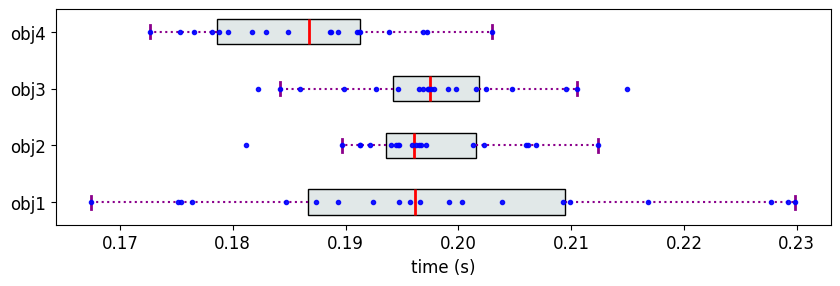

In [21]:
obj_params = {}
obj_params['obj1']  = [0.2,0.02] # [mean, std]
obj_params['obj2']  = [0.2,0.01]
obj_params['obj3']  = [0.2,0.01]
obj_params['obj4']  = [0.19,0.01]
ms = MeasurementsSimulator(obj_params,seed=129)
reps = 20
ms.measure(reps=reps)
measurements = ms.get_measurements()
h0 = list(obj_params.keys())
mv = MeasurementsVisualizer(measurements, h0)
fig = mv.show_measurements_boxplots(scale=0.7)

### Usage

In [22]:
cm = QuantileComparer(measurements)

In [23]:
cm.compute_quantiles(75, 25,False)

In [25]:
cm.C

{'obj1': {'obj1': -1, 'obj2': -1, 'obj3': -1, 'obj4': -1},
 'obj2': {'obj1': -1, 'obj2': -1, 'obj3': -1, 'obj4': -1},
 'obj3': {'obj1': -1, 'obj2': -1, 'obj3': -1, 'obj4': -1},
 'obj4': {'obj1': -1, 'obj2': -1, 'obj3': -1, 'obj4': -1}}

In [27]:
cm.t_up

{'obj1': 0.20941589934262114,
 'obj2': 0.20152257141153468,
 'obj3': 0.20180914682702059,
 'obj4': 0.1912447276655392}

In [28]:
cm.t_low

{'obj1': 0.18669566987835842,
 'obj2': 0.19358304170962462,
 'obj3': 0.19419698326830245,
 'obj4': 0.17863428365515255}

In [29]:
cm.better_than_relation('obj4','obj3')

0

In [30]:
cm.compare()

In [31]:
cm.C

{'obj1': {'obj1': -1, 'obj2': 1, 'obj3': 1, 'obj4': 1},
 'obj2': {'obj1': 1, 'obj2': -1, 'obj3': 1, 'obj4': 2},
 'obj3': {'obj1': 1, 'obj2': 1, 'obj3': -1, 'obj4': 2},
 'obj4': {'obj1': 1, 'obj2': 0, 'obj3': 0, 'obj4': -1}}

In [32]:
x = pd.DataFrame(cm.C)
x

,obj1,obj2,obj3,obj4
obj1,-1,1,1,1
obj2,1,-1,1,0
obj3,1,1,-1,0
obj4,1,2,2,-1


In [33]:
dict(x.apply(lambda row: row[row == 0].index.tolist(), axis=1))

{'obj1': [], 'obj2': ['obj4'], 'obj3': ['obj4'], 'obj4': []}

### Scaling test

In [79]:
def create_measurements(n_objs, n_reps, seed=129):
    obj_params = {}
    for i in range(n_objs):
        obj_params[f'obj{i}'] = [np.random.uniform(0,1), np.random.uniform(0,0.1)]
    ms = MeasurementsSimulator(obj_params,seed=seed)
    ms.measure(reps=n_reps)
    return ms.get_measurements()

In [80]:
measurements = create_measurements(1000, 5)

In [81]:
cm = QuantileComparer(measurements)

In [82]:
%%timeit -n 1 -r 3
cm.compute_quantiles(75, 25,False)
cm.compare()

743 ms ± 168 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
